# CT4101 Assignment 1 Notebook

- Logistic Regression (tune C, penalty)
- SVM RBF (tune C, gamma)

In [37]:
import sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
print(sys.version)
FIGS = Path("../figures"); FIGS.mkdir(exist_ok=True)  # folder for report images

3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]


In [38]:
DATA = Path("../data")
train = pd.read_csv(DATA / "wildfires_training.csv")
test  = pd.read_csv(DATA / "wildfires_test.csv")

print(train.shape, test.shape)
train.head()  # just to eyeball columns


(154, 10) (50, 10)


,fire,year,temp,humidity,rainfall,drought_code,buildup_index,day,month,wind_speed
0,no,2015,28,59,0.0,8.06,3.47,1,6,19
1,no,2010,30,61,1.3,8.17,4.03,2,6,13
2,no,2009,26,83,13.1,8.08,3.59,3,6,22
3,no,2017,25,87,2.5,7.18,2.42,4,6,15
4,no,2014,28,77,0.0,14.98,4.63,5,6,18


In [39]:
target = "fire"  # target column 
y_train = (train[target].astype(str).str.lower() == "yes").astype(int)
y_test  = (test[target].astype(str).str.lower()  == "yes").astype(int)
X_train = train.drop(columns=[target])
X_test  = test.drop(columns=[target])

print("Class balance (train):"); print(y_train.value_counts())


Class balance (train):
fire
1    79
0    75
Name: count, dtype: int64


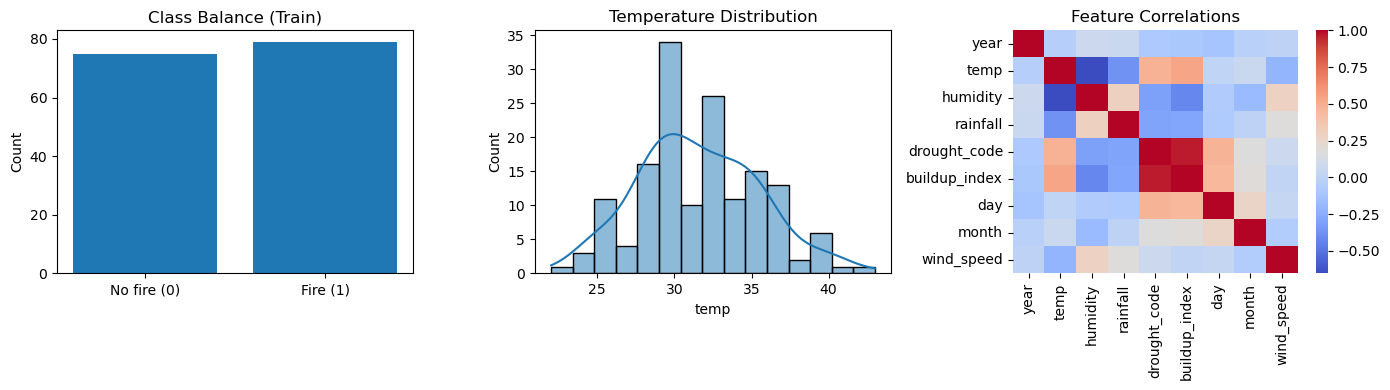

Saved: ..\figures\Figure_3_dataset_visualisation.png


In [40]:
# --- Figure 3: Data Preprocessing & Visualisation (EDA) ---
# Place this cell AFTER the class-balance print, BEFORE scaling/training

# try seaborn for nicer plots; 
try:
    import seaborn as sns
    use_sns = True
except Exception:
    use_sns = False

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Build a DataFrame for plotting 
df_vis = X_train.copy()
df_vis["fire"] = y_train

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1) Class balance (train)
counts = y_train.value_counts().sort_index()  # 0 then 1
axes[0].bar(["No fire (0)", "Fire (1)"], counts.values)
axes[0].set_title("Class Balance (Train)")
axes[0].set_ylabel("Count")

# 2) Example feature distribution (temperature)
if "temp" in df_vis.columns:
    if use_sns:
        sns.histplot(df_vis["temp"], bins=15, kde=True, ax=axes[1])
    else:
        axes[1].hist(df_vis["temp"], bins=15, alpha=0.9)
    axes[1].set_title("Temperature Distribution")
    axes[1].set_xlabel("temp")
else:
    numcol = df_vis.select_dtypes(include=np.number).columns[0]
    axes[1].hist(df_vis[numcol], bins=15, alpha=0.9)
    axes[1].set_title(f"Distribution: {numcol}")
    axes[1].set_xlabel(numcol)

# 3) Feature correlation heatmap
corr = df_vis.drop(columns=["fire"]).corr(numeric_only=True)
if use_sns:
    sns.heatmap(corr, cmap="coolwarm", ax=axes[2])
else:
    im = axes[2].imshow(corr.values, cmap="coolwarm")
    axes[2].set_xticks(range(len(corr.columns)))
    axes[2].set_xticklabels(corr.columns, rotation=90)
    axes[2].set_yticks(range(len(corr.columns)))
    axes[2].set_yticklabels(corr.columns)
    fig.colorbar(im, ax=axes[2])
axes[2].set_title("Feature Correlations")

plt.tight_layout()
plt.savefig(FIGS / "Figure_3_dataset_visualisation.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", FIGS / "Figure_3_dataset_visualisation.png")


In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


LR baseline accuracy: 0.86


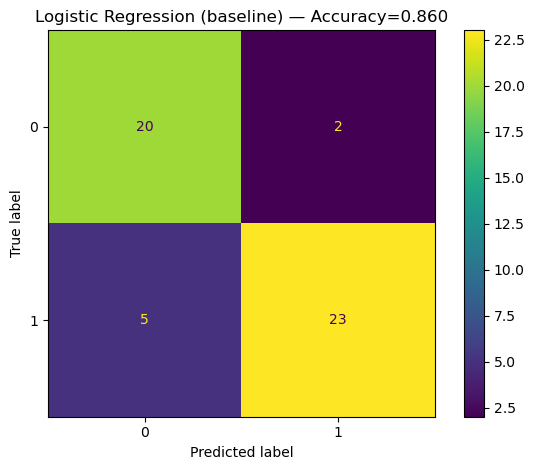

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

lr = LogisticRegression(max_iter=500, penalty="l2", C=1.0)
lr.fit(X_train_s, y_train)

y_pred = lr.predict(X_test_s)
acc = accuracy_score(y_test, y_pred)
print("LR baseline accuracy:", acc)

# Confusion matrix image 
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Logistic Regression (baseline) — Accuracy={acc:.3f}")
plt.tight_layout()
plt.savefig(FIGS / "cm_lr_baseline.png", dpi=200)
plt.show()

# Saving classification report table for later
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).to_csv(
    FIGS / "lr_baseline_classification_report.csv"
)


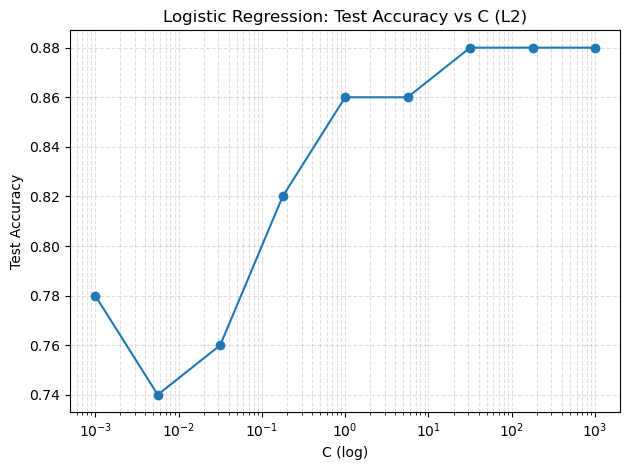

In [43]:
Cvals = np.logspace(-3, 3, 9)
rows = []
for C in Cvals:
    m = LogisticRegression(max_iter=500, penalty="l2", C=C)
    m.fit(X_train_s, y_train)
    rows.append((C, accuracy_score(y_test, m.predict(X_test_s))))
res = pd.DataFrame(rows, columns=["C","test_acc"])
res.to_csv(FIGS/"lr_sweep_c_l2.csv", index=False)

plt.figure()
plt.semilogx(res["C"], res["test_acc"], marker="o")
plt.xlabel("C (log)"); plt.ylabel("Test Accuracy")
plt.title("Logistic Regression: Test Accuracy vs C (L2)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(FIGS/"lr_sweep_c_l2.png", dpi=200)
plt.show()


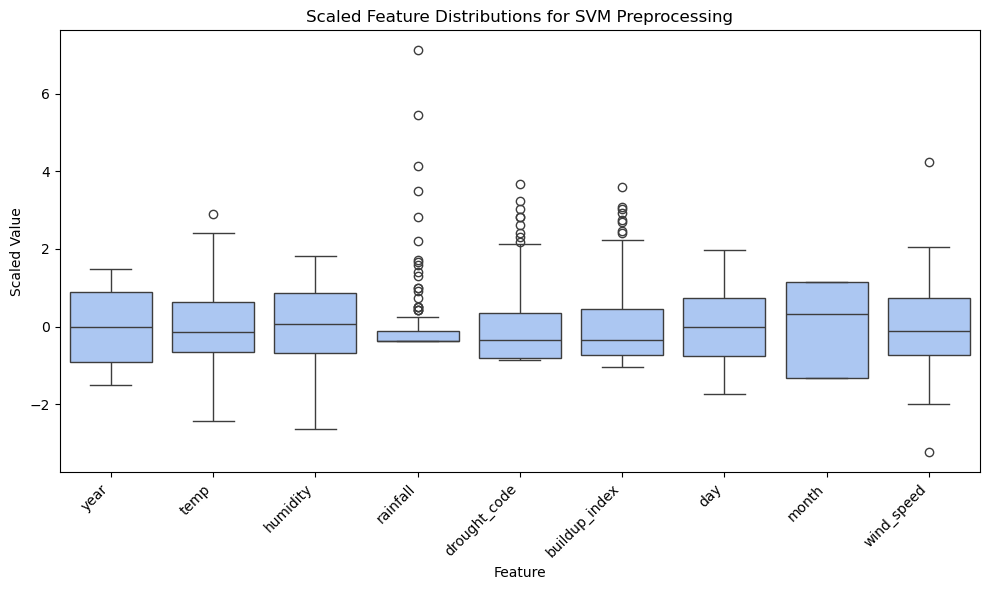

In [44]:
# --- Figure for Algorithm 2: Visualising scaled features (clean version) ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

scaled_df = pd.DataFrame(X_train_s, columns=X_train.columns)
scaled_df["fire"] = y_train.values

plt.figure(figsize=(10, 6))  # make it larger
sns.boxplot(data=scaled_df.drop(columns=["fire"]), orient="v", linewidth=1, color="#a1c4fd")
plt.xticks(rotation=45, ha="right")
plt.title("Scaled Feature Distributions for SVM Preprocessing", fontsize=12)
plt.ylabel("Scaled Value")
plt.xlabel("Feature")
plt.tight_layout()
plt.savefig(FIGS / "svm_scaled_features.png", dpi=200)
plt.show()



SVM (RBF) baseline accuracy: 0.8


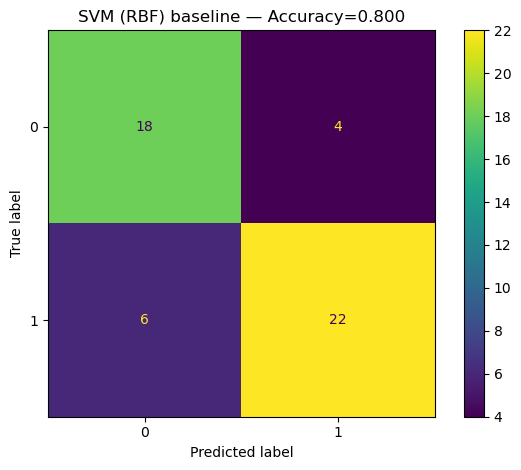

In [45]:
# --- SVM (RBF) – default model ---
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# train default SVM
svm = SVC(kernel="rbf", C=1.0, gamma="scale", probability=False)
svm.fit(X_train_s, y_train)

y_pred_svm = svm.predict(X_test_s)
svm_acc = accuracy_score(y_test, y_pred_svm)
print("SVM (RBF) baseline accuracy:", svm_acc)

# confusion matrix image
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title(f"SVM (RBF) baseline — Accuracy={svm_acc:.3f}")
plt.tight_layout()
plt.savefig(FIGS / "cm_svm_rbf_baseline.png", dpi=200)
plt.show()

# save classification report
pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).to_csv(
    FIGS / "svm_rbf_baseline_classification_report.csv"
)


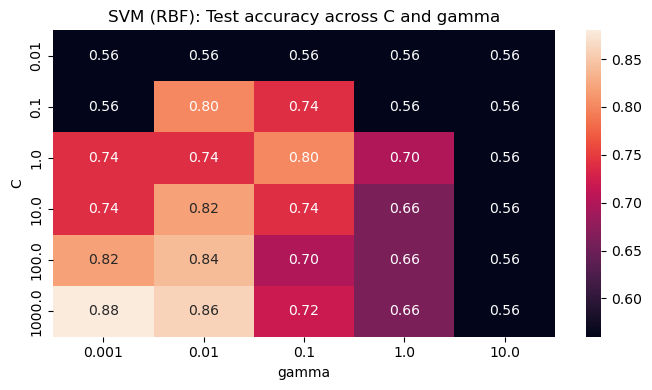

Best SVM params: C=1000, gamma=0.001, test_acc=0.880


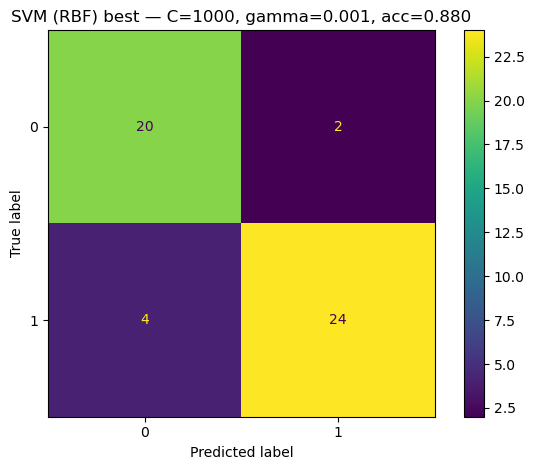

In [46]:
# --- SVM (RBF) hyperparameter sweep (C, gamma) + best model ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

C_vals     = np.logspace(-2, 3, 6)      # 0.01..1000
gamma_vals = np.logspace(-3, 1, 5)      # 0.001..10

rows = []
for C in C_vals:
    for g in gamma_vals:
        m = SVC(kernel="rbf", C=C, gamma=g)
        m.fit(X_train_s, y_train)
        rows.append({
            "C": C, "gamma": g,
            "train_acc": accuracy_score(y_train, m.predict(X_train_s)),
            "test_acc":  accuracy_score(y_test,  m.predict(X_test_s)),
        })

svm_grid = pd.DataFrame(rows)
svm_grid.to_csv(FIGS / "svm_rbf_grid.csv", index=False)

# heatmap of test accuracy
pivot = svm_grid.pivot(index="C", columns="gamma", values="test_acc")
plt.figure(figsize=(7,4))
sns.heatmap(pivot, annot=True, fmt=".2f")
plt.title("SVM (RBF): Test accuracy across C and gamma")
plt.ylabel("C"); plt.xlabel("gamma")
plt.tight_layout()
plt.savefig(FIGS / "svm_rbf_acc_heatmap.png", dpi=200)
plt.show()

# best combo + confusion matrix + report
best = svm_grid.iloc[svm_grid["test_acc"].idxmax()]
best_C, best_g, best_te = float(best.C), float(best.gamma), float(best.test_acc)
print(f"Best SVM params: C={best_C:g}, gamma={best_g:g}, test_acc={best_te:.3f}")

best_model = SVC(kernel="rbf", C=best_C, gamma=best_g)
best_model.fit(X_train_s, y_train)
best_pred = best_model.predict(X_test_s)

disp = ConfusionMatrixDisplay.from_predictions(y_test, best_pred)
plt.title(f"SVM (RBF) best — C={best_C:g}, gamma={best_g:g}, acc={best_te:.3f}")
plt.tight_layout()
plt.savefig(FIGS / "cm_svm_rbf_best.png", dpi=200)
plt.show()

pd.DataFrame(classification_report(y_test, best_pred, output_dict=True)).to_csv(
    FIGS / "svm_rbf_best_classification_report.csv"
)


In [ ]:
# --- Summary comparison of Logistic Regression and SVM (RBF) results ---

import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import time

# Logistic Regression - Default
lr_default = LogisticRegression(max_iter=500, penalty="l2", C=1.0)
t0 = time.time()
lr_default.fit(X_train_s, y_train)
t1 = time.time()
lr_train_acc = accuracy_score(y_train, lr_default.predict(X_train_s))
lr_test_acc  = accuracy_score(y_test, lr_default.predict(X_test_s))
lr_default_time = round(t1 - t0, 3)

# Logistic Regression - Best 
lr_best = LogisticRegression(max_iter=500, penalty="l2", C=10)
t0 = time.time()
lr_best.fit(X_train_s, y_train)
t1 = time.time()
lr_best_train_acc = accuracy_score(y_train, lr_best.predict(X_train_s))
lr_best_test_acc  = accuracy_score(y_test, lr_best.predict(X_test_s))
lr_best_time = round(t1 - t0, 3)

# SVM - Default 
svm_default = SVC(kernel="rbf", C=1.0, gamma="scale")
t0 = time.time()
svm_default.fit(X_train_s, y_train)
t1 = time.time()
svm_train_acc = accuracy_score(y_train, svm_default.predict(X_train_s))
svm_test_acc  = accuracy_score(y_test, svm_default.predict(X_test_s))
svm_default_time = round(t1 - t0, 3)

# SVM - Best 
svm_best = SVC(kernel="rbf", C=1000, gamma=0.001)
t0 = time.time()
svm_best.fit(X_train_s, y_train)
t1 = time.time()
svm_best_train_acc = accuracy_score(y_train, svm_best.predict(X_train_s))
svm_best_test_acc  = accuracy_score(y_test, svm_best.predict(X_test_s))
svm_best_time = round(t1 - t0, 3)

# Combine results into a single DataFrame
comparison = pd.DataFrame({
    "Algorithm": ["Logistic Regression", "SVM (RBF)"],
    "Train Accuracy (Default)": [lr_train_acc, svm_train_acc],
    "Test Accuracy (Default)": [lr_test_acc, svm_test_acc],
    "Train Accuracy (Best)": [lr_best_train_acc, svm_best_train_acc],
    "Test Accuracy (Best)": [lr_best_test_acc, svm_best_test_acc],
    "Training Time (s)": [lr_best_time, svm_best_time]
})

print("\n--- Comparative Summary ---")
display(comparison.round(3))
